Consider a current $I$ flowing counterclockwise in a loop in the xy-plane with a 3-petal shape as follows:

$$\vec{l}(t) = R\left[1+\frac{3}{4}\sin(3 t)\right] \cdot \left<\cos t, \sin t, 0 \right> $$

where $0 \leq t \leq 2\pi$. The Biot-Savard Law tells us

$$\vec{B}(\vec{r}) =  \frac{\mu_0 I}{4 \pi} \int_C \frac{d\vec{l} \times (\vec{r}-\vec{l})}{|\vec{r}-\vec{l}|^3} = \int_0^{2 \pi} \frac{d\vec{l}/dt \times (\vec{r} - \vec{l})}{|\vec{r}-\vec{l}|^3} dt$$

Putting this in dimensionless form

* $\vec{l} \to \vec{l}/R$
* $\vec{r} \to \vec{r}/R$

we get

$$\frac{4 \pi R}{\mu_0 I} \vec{B}(\vec{r}) = \int_0^{2 \pi} \frac{d\vec{l}/dt \times (\vec{r} - \vec{l})}{|\vec{r}-\vec{l}|^3} dt$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, quad_vec
import plotly.graph_objects as go
import plotly.io as pio
from scipy import integrate
pio.renderers.default = 'iframe'
from IPython.display import HTML
import sympy as smp
from sympy.vector import cross

Start by looking at curve

In [2]:
phi = np.linspace(0, 1, 100)

def l(phi, radius=1):
    return radius * np.array([np.cos(2*np.pi*phi), np.sin(2*np.pi*phi), np.zeros(len(phi))])

def l2(t, length=1, direction=[1, 0, 0], start_point=[-1, 0, 0]):
    direction = np.array(direction)
    # Normalize the direction vector
    direction = direction / np.linalg.norm(direction)
    # Create line in the specified direction starting at the specified point
    start_point = np.array(start_point).reshape(3, 1)
    line = start_point + length * np.array([
        direction[0] * t,
        direction[1] * t,
        direction[2] * t
    ])
    return line


In [3]:
lx, ly, lz = l(phi, radius=2)
l2x,l2y,l2z = l2(phi, length=2, direction=[1,0,0])

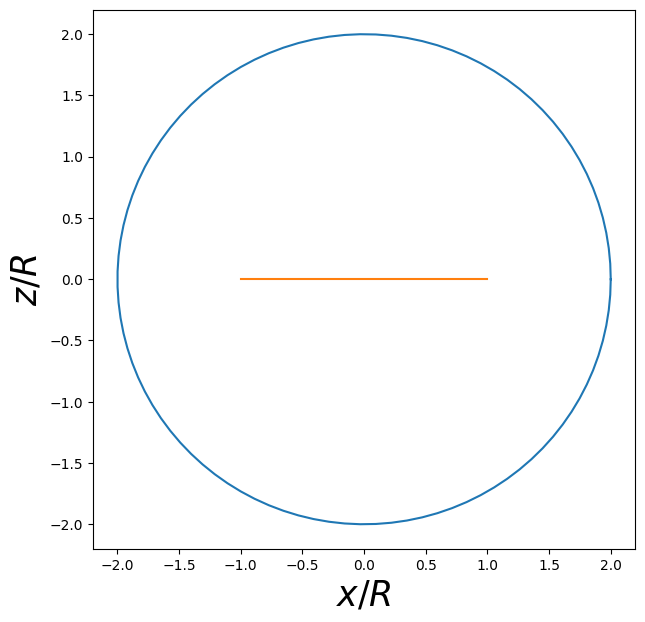

In [4]:
plt.figure(figsize=(7,7))
plt.plot(lx, ly)
plt.plot(l2x, l2y)
plt.xlabel('$x/R$', fontsize=25)
plt.ylabel('$z/R$', fontsize=25)
plt.show()

Lets solve for the integrand using sympy

In [5]:
t, x, y, z = smp.symbols('t, x, y, z')

Get $l$, $r$, and the seperation vector $\vec{r} - \vec{l}$

In [6]:
#l = 2*smp.Matrix([smp.cos(t), smp.sin(t), 0])
l = [smp.Matrix([-1+2*t,0,0]), 2*smp.Matrix([smp.cos(2*np.pi*t), smp.sin(2*np.pi*t), 0])]
r = smp.Matrix([x, y, z])
sep = []
for lt in l:
    sep.append(r-lt)

In [7]:
l[1]

Matrix([
[2*cos(6.28318530717959*t)],
[2*sin(6.28318530717959*t)],
[                        0]])

Define the integrand

In [8]:
sep[1]

Matrix([
[x - 2*cos(6.28318530717959*t)],
[y - 2*sin(6.28318530717959*t)],
[                            z]])

In [9]:
integrand = []
for indice, lt in enumerate(l):
    integrand.append(smp.diff(lt,t).cross(sep[indice]) / sep[indice].norm()**3)

In [10]:
integrand[1]

Matrix([
[                                                                                                            12.5663706143592*z*cos(6.28318530717959*t)/(Abs(z)**2 + Abs(x - 2*cos(6.28318530717959*t))**2 + Abs(y - 2*sin(6.28318530717959*t))**2)**(3/2)],
[                                                                                                            12.5663706143592*z*sin(6.28318530717959*t)/(Abs(z)**2 + Abs(x - 2*cos(6.28318530717959*t))**2 + Abs(y - 2*sin(6.28318530717959*t))**2)**(3/2)],
[(-12.5663706143592*(x - 2*cos(6.28318530717959*t))*cos(6.28318530717959*t) - 12.5663706143592*(y - 2*sin(6.28318530717959*t))*sin(6.28318530717959*t))/(Abs(z)**2 + Abs(x - 2*cos(6.28318530717959*t))**2 + Abs(y - 2*sin(6.28318530717959*t))**2)**(3/2)]])

Get the $x$, $y$, and $z$ components of the integrand

In [11]:
dbx = []
dby = []
dbz = []
for indice, lt in enumerate(l):
    dbx.append(smp.lambdify([t, x, y, z], integrand[indice][0]))
    dby.append(smp.lambdify([t, x, y, z], integrand[indice][1]))
    dbz.append(smp.lambdify([t, x, y, z], integrand[indice][2]))

'\ndBxdt = smp.lambdify([t, x, y, z], integrand[0])\ndBydt = smp.lambdify([t, x, y, z], integrand[1])\ndBzdt = smp.lambdify([t, x, y, z], integrand[2])\n'

Get the magnetic field by performing the integral over each component

In [12]:
# Para un dBdt
def B(dBxdt, dBydt, dBzdt, x, y, z):
    Bx = np.zeros_like(x) + quad_vec(dBxdt, 0, 1, args=(x, y, z))[0]
    By = np.zeros_like(y) + quad_vec(dBydt, 0, 1, args=(x, y, z))[0]
    Bz = np.zeros_like(z) + quad_vec(dBzdt, 0, 1, args=(x, y, z))[0]
    
    return np.array([Bx,
                     By,
                     Bz])

Set up a meshgrid to solve for the field in some 3D volume

In [13]:
x = np.linspace(-2, 2, 20)
xv, yv, zv = np.meshgrid(x, x, x)

In [14]:
B_total = np.array([np.zeros_like(xv), np.zeros_like(yv), np.zeros_like(zv)])
for indice, lt in enumerate(l):
    B_total = B_total + B(dbx[indice], dby[indice], dbz[indice], xv, yv, zv)
Bx, By, Bz = B_total

In [15]:
"""
Bx[Bx>20] = 20
By[By>20] = 20
Bz[Bz>20] = 20

Bx[Bx<-20] = -20
By[By<-20] = -20
Bz[Bz<-20] = -20
"""

'\nBx[Bx>20] = 20\nBy[By>20] = 20\nBz[Bz>20] = 20\n\nBx[Bx<-20] = -20\nBy[By<-20] = -20\nBz[Bz<-20] = -20\n'

Use plotly to make an interactive 3D plot

In [16]:
data = go.Cone(x=xv.ravel(), y=yv.ravel(), z=zv.ravel(),
               u=Bx.ravel(), v=By.ravel(), w=Bz.ravel(),
               colorscale='Inferno', colorbar=dict(title='$x^2$'),
               sizemode="absolute", sizeref=20)

layout = go.Layout(title=r'Plot Title',
                     scene=dict(xaxis_title=r'x',
                                yaxis_title=r'y',
                                zaxis_title=r'z',
                                aspectratio=dict(x=1, y=1, z=1),
                                camera_eye=dict(x=1.2, y=1.2, z=1.2)))

fig = go.Figure(data = data, layout=layout)
fig.add_scatter3d(x=lx, y=ly, z=lz, mode='lines',
                  line = dict(color='green', width=10))
fig.add_scatter3d(x=l2x, y=l2y, z=l2z, mode='lines',
                  line = dict(color='green', width=10))